

# 1.1 Import Libraries and Data

In [1]:
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

# General Libraries
import numpy as np
import pandas as pd
import pickle
import category_encoders as ce

# Import plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 

# Sklearn Specific
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from sklearn import preprocessing

# sklearn algos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # SGD
from sklearn.neural_network import MLPClassifier # neural network (multilayer perceptron)

# Bayesian Hyperparameter optimization
from hyperopt import hp, tpe, fmin, space_eval, Trials

# Import Data
with open('../data/temp_data/data_dicts_v2.pickle', 'rb') as handle:
    data_dicts = pickle.load(handle)

# 1.2 Functions

In [2]:
def split_encode_standardize(df):
     # Split features and labels
    
    y = df['result'].astype('int')
    
    
    X = df.iloc[:,4:]
    X = X.drop(['result'], axis = 1)
    X = X.fillna(0)

    # Wrangle 
    X['f_stance'] = X.apply(lambda x: str(x['f_stance']), axis = 1)
    X['o_stance'] = X.apply(lambda x: str(x['o_stance']), axis = 1)

    # Encode categorical data
    ce_binary = ce.BinaryEncoder(cols = ['f_stance','o_stance'])
    X = ce_binary.fit_transform(X, y)
    # Scale features with mean = 0 and sd = 1
    X = preprocessing.scale(X)
    
    return(X,y)

def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

# 2. Setup Bayesian Hyperparameter Optimization

In [3]:
def objective_function(params):
    """Objective function to minimize: (1- cross validated test_accuracy_score)"""
    
    h_model = params['model']  # Gets the model name
    del params['model'] # Gets the hyperparameters
    
    # Initialize model with parameters
    if h_model == "RandomForestClassifier":
        model = RandomForestClassifier(**params)
    elif h_model == "KNeighborsClassifier":
        model = KNeighborsClassifier(**params)
    elif h_model == "LogisticRegression":
        model = LogisticRegression(**params)
    elif h_model == "SVC":
        model = svm.SVC(**params)
    elif h_model == "DecisionTreeClassifier":
        model = DecisionTreeClassifier(**params)
    elif h_model == "GaussianNB":
        model = GaussianNB(**params)
    elif h_model == "Perceptron":
        model = Perceptron(**params)
    elif h_model == "SGDClassifier":
        model = SGDClassifier(**params)
    elif h_model == "MLPClassifier":
        model = MLPClassifier(**params)
    
    
    scoring_stats = {'accuracy': 'accuracy',
               'recall': 'recall',
               'precision': 'precision',
               'roc_auc': 'roc_auc'}
    
    avg_scores = cross_validate(model, X, y, cv=5, scoring = scoring_stats)

    cv_accuracy = np.mean(avg_scores['test_accuracy'])
    return(1 - cv_accuracy)

def get_space(model):
    model_name = type(model).__name__
    
            
    if model_name == "LogisticRegression":
        space_dict = {'model': model_name,
                      'dual': hp.choice('dual', [True,False]),
                      'fit_intercept': hp.choice('fit_intercept', [True,False])}
        
    elif model_name == "RandomForestClassifier":
        space_dict = {'model' : model_name,
                      'max_depth': hp.choice('max_depth', range(1,50)),
                      'max_features': hp.choice('max_features', range(1,50)),
                      'n_estimators': hp.choice('n_estimators', range(1,50)),}
        
    elif model_name == "SVC": # Fix space dict
        space_dict = {'model': model_name,
                      'kernel': hp.choice('kernel',['linear','poly','rbf','sigmoid']),
                      'shrinking': hp.choice('shrinking', [True, False])}
        
    elif model_name == "KNeighborsClassifier":
        space_dict = {'model': model_name,
                      'n_neighbors': hp.choice('n_neighbors', range(1,100)),
                      'weights': hp.choice('weights', ['uniform', 'distance']),
                      'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
                      'leaf_size': hp.choice('leaf_size', range(1,60))}
    
    elif model_name == "DecisionTreeClassifier":
        space_dict = {'model': model_name,
                      'criterion': hp.choice('criterion', ['gini','entropy']),
                      'splitter': hp.choice('splitter', ['best','random']),
                      'max_features': hp.choice('max_features', ['auto','sqrt','log2']),
                    }
    
    elif model_name == "GaussianNB":
        space_dict = {'model': model_name,
                      'var_smoothing': hp.uniform('var_smoothing', 1e-15, 1e-3)}
    
    elif model_name == "Perceptron":
        space_dict = {'model': model_name,
                      'alpha': hp.uniform('alpha', 1e-15, 1e-3),
                      'fit_intercept': hp.choice('fit_intercept', [True,False])}
    
    elif model_name == "SGDClassifier":
        space_dict = {'model': model_name,
                      'fit_intercept': hp.choice('fit_intercept', [True,False]),
                      'loss': hp.choice('loss', ['hinge','squared_hinge'])
                     }
    
    elif model_name == "MLPClassifier":
        space_dict = {'model': model_name,
                      'activation': hp.choice('activation ', ['identity','logistic','tanh','relu'])}
    

    return(space_dict)   

def get_max_evals(model_name):
    if model_name == "LogisticRegression":
        num_evals = 20
        
    elif model_name == "RandomForestClassifier":
        num_evals = 50
        
    elif model_name == "SVC": 
        num_evals = 20
        
    elif model_name == "KNeighborsClassifier":
        num_evals = 20
    
    elif model_name == "DecisionTreeClassifier":
        num_evals = 20
        
    elif model_name == "GaussianNB":
        num_evals = 10
    
    elif model_name == "Perceptron":
        num_evals = 10
    
    elif model_name == "SGDClassifier":
        num_evals = 20
    
    elif model_name == "MLPClassifier":
        num_evals = 20
        
    return(num_evals)

# 3. Initialize Models and Generate Dictionary for Results

In [4]:
# Initialize models
models = []

blr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = svm.SVC()
knn_clf = KNeighborsClassifier()
dtree_clf = DecisionTreeClassifier()
nb_clf = GaussianNB()
perc_clf = Perceptron()
sgd_clf = SGDClassifier()
mlp_clf = MLPClassifier()

# add models to a list
models.extend((blr_clf,rf_clf,svm_clf,knn_clf, dtree_clf, nb_clf, perc_clf, sgd_clf, mlp_clf))

# Initialize a dictionary for scores, dataset
score_d = {}
score_d['hyper_opt_par'] = []
score_d['dict_type'] = []
score_d['dataset'] = []
score_d['num_obs'] = []
score_d['model_name'] = []
score_d['accuracy'] = []
score_d['precision'] = []
score_d['recall'] = []
score_d['roc_auc'] = []
score_d['hp_dict'] = []

# 5. Train and print scores for each model

In [5]:
cumu_dfs_dict = data_dicts[0]

In [6]:
fe_cumu_dfs_dict = data_dicts[1]

In [7]:
test_exact = fe_cumu_dfs_dict['Cumulative Data: 1 Fight Lookback Window']

In [8]:
dict_key = 1
for data_dict in data_dicts:

    
    df_index = 0
    for key in data_dict:
        df_index += 1

        if (df_index <= 0):
            continue
        
        if dict_key == 1:
            dict_type = "cumu_dfs_dict"
        else:
            dict_type = "ef_cumu_dfs_dict"
        df = data_dict[key].copy()

        dataset = key
        num_obs = df.shape[0]

        X,y = split_encode_standardize(df)

        for model in models:
            model_name = type(model).__name__

            print(model_name)

            space = get_space(model) # Get space
            
           # number_of_evals = get_max_evals(model_name) # get_max_evals from testing
            
            best_h = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=5)
            opt_hp = space_eval(space, best_h)
            
            score_d['hyper_opt_par'].append(opt_hp)

            print(opt_hp)
            del opt_hp['model']

            # create new model with tuned hyperparameters
            if model_name == "RandomForestClassifier":
                ht_model = RandomForestClassifier(**opt_hp)

            elif model_name == "KNeighborsClassifier":
                ht_model = KNeighborsClassifier(**opt_hp)

            elif model_name == "LogisticRegression":
                ht_model = LogisticRegression(**opt_hp)
            elif model_name == "SVC":
                ht_model = svm.SVC(**opt_hp)
            elif model_name == "DecisionTreeClassifier":
                ht_model = DecisionTreeClassifier(**opt_hp)
            elif model_name == "GaussianNB":
                ht_model = GaussianNB(**opt_hp)
            elif model_name == "Perceptron":
                ht_model = Perceptron(**opt_hp)
            elif model_name == "SGDClassifier":
                ht_model = SGDClassifier(**opt_hp)
            elif model_name == "MLPClassifier":
                ht_model = MLPClassifier(**opt_hp)
            
            


            scoring_stats = {'accuracy': 'accuracy',
                   'recall': 'recall',
                   'precision': 'precision',
                   'roc_auc': 'roc_auc'}    



            # Calculate scores
            avg_scores = cross_validate(ht_model, X, y, cv=5, scoring = scoring_stats)

            accuracy = np.mean(avg_scores['test_accuracy'])
            precision = np.mean(avg_scores['test_precision'])
            recall = np.mean(avg_scores['test_recall'])
            roc_auc = np.mean(avg_scores['test_roc_auc'])

            # append to dictionary
            score_d['dict_type'].append(dict_type)
            score_d['dataset'].append(dataset)
            score_d['num_obs'].append(num_obs)
            score_d['model_name'].append(model_name)
            score_d['accuracy'].append(accuracy)
            score_d['precision'].append(precision)
            score_d['recall'].append(recall)
            score_d['roc_auc'].append(roc_auc)
            score_d['hp_dict'].append(opt_hp)
            
    dict_key += 1

LogisticRegression
100%|██████████| 5/5 [00:04<00:00,  1.13it/s, best loss: 0.4658656299406907]
{'dual': True, 'fit_intercept': False, 'model': 'LogisticRegression'}
RandomForestClassifier
100%|██████████| 5/5 [01:03<00:00, 12.51s/it, best loss: 0.4848132052901466]
{'max_depth': 19, 'max_features': 46, 'model': 'RandomForestClassifier', 'n_estimators': 39}
SVC
100%|██████████| 5/5 [04:10<00:00, 53.20s/it, best loss: 0.47598500121295273]
{'kernel': 'linear', 'model': 'SVC', 'shrinking': False}
KNeighborsClassifier
100%|██████████| 5/5 [04:04<00:00, 47.99s/it, best loss: 0.4796083835941879]
{'algorithm': 'kd_tree', 'leaf_size': 49, 'model': 'KNeighborsClassifier', 'n_neighbors': 75, 'weights': 'uniform'}
DecisionTreeClassifier
100%|██████████| 5/5 [00:01<00:00,  3.50it/s, best loss: 0.49233142049304435]
{'criterion': 'gini', 'max_features': 'log2', 'model': 'DecisionTreeClassifier', 'splitter': 'random'}
GaussianNB
100%|██████████| 5/5 [00:01<00:00,  3.08it/s, best loss: 0.49276473737483

100%|██████████| 5/5 [00:02<00:00,  1.98it/s, best loss: 0.49146415934015375]
{'model': 'GaussianNB', 'var_smoothing': 0.0008167526692034373}
Perceptron
100%|██████████| 5/5 [00:00<00:00,  6.57it/s, best loss: 0.48090247860602464]
{'alpha': 0.0009697849240791764, 'fit_intercept': False, 'model': 'Perceptron'}
SGDClassifier
100%|██████████| 5/5 [00:00<00:00,  6.99it/s, best loss: 0.48726797052106774]
{'fit_intercept': True, 'loss': 'hinge', 'model': 'SGDClassifier'}
MLPClassifier
100%|██████████| 5/5 [02:11<00:00, 28.42s/it, best loss: 0.46889780246438517]
{'activation': 'identity', 'model': 'MLPClassifier'}
LogisticRegression
100%|██████████| 5/5 [00:03<00:00,  1.49it/s, best loss: 0.46904653684177255]
{'dual': False, 'fit_intercept': False, 'model': 'LogisticRegression'}
RandomForestClassifier
100%|██████████| 5/5 [00:06<00:00,  1.32s/it, best loss: 0.48360732813513485]
{'max_depth': 4, 'max_features': 28, 'model': 'RandomForestClassifier', 'n_estimators': 32}
SVC
100%|██████████| 5/5

In [9]:
scores_dict = without_keys(score_d, 'hp_dict')
scores_df = pd.DataFrame(scores_dict)
scores_df

,hyper_opt_par,dict_type,dataset,num_obs,model_name,accuracy,precision,recall,roc_auc
0,"{'dual': True, 'fit_intercept': False}",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,LogisticRegression,0.531531,0.523686,0.527937,0.541079
1,"{'max_depth': 19, 'max_features': 46, 'n_estim...",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,RandomForestClassifier,0.511712,0.504339,0.486182,0.520659
2,"{'kernel': 'linear', 'shrinking': False}",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,SVC,0.524015,0.520267,0.437104,0.533964
3,"{'algorithm': 'kd_tree', 'leaf_size': 49, 'n_n...",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,KNeighborsClassifier,0.520392,0.514082,0.457073,0.519940
4,"{'criterion': 'gini', 'max_features': 'log2', ...",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,DecisionTreeClassifier,0.501444,0.493532,0.492655,0.501306
5,{'var_smoothing': 0.0006778797837565959},cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,GaussianNB,0.507235,0.500029,0.700762,0.527431
6,"{'alpha': 0.0006281474581602776, 'fit_intercep...",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,Perceptron,0.510705,0.503544,0.524108,0.516493
7,"{'fit_intercept': True, 'loss': 'hinge'}",cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,SGDClassifier,0.487414,0.475908,0.428820,0.482435
8,{'activation': 'identity'},cumu_dfs_dict,Exact Data: 1 Fight Lookback Window,6914,MLPClassifier,0.524583,0.519993,0.450928,0.535765
9,"{'dual': False, 'fit_intercept': True}",cumu_dfs_dict,Exact Data: 3 Fight Lookback Window,3780,LogisticRegression,0.534916,0.528913,0.497597,0.542696


In [10]:
non_fe = scores_df[scores_df['dict_type'] == "cumu_dfs_dict"]
yes_fe = scores_df[scores_df['dict_type'] == "ef_cumu_dfs_dict"]

In [13]:
print("The mean non-fe accuracy is: " + str(np.mean(non_fe['accuracy'])))
print("The mean fe accuracy is: " + str(np.mean(yes_fe['accuracy'])))

The mean non-fe accuracy is: 0.5313580019644094
The mean fe accuracy is: 0.5309813223916977


In [12]:
scores_df.to_csv("../data/scores/hopt_scores_v3.csv")

In [15]:
# save dictionary using pickle
with open('../data/temp_data/hyperopt.pickle', 'wb') as handle:
    pickle.dump(scores_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('../data/temp_data/hyperopt.pickle', 'rb') as handle:
    hyperopt_dict = pickle.load(handle)

# Preliminary Analysis
- The hyperparameters from the sklearn classifiers were set to their defaults and will be tuned. 


- Nevertheless, the effectiveness of each model appears to vary based off the length of the look back number. I will soon be transforming the printed text data above into nicer looking graphs.  


- Please scroll around in the above cell to view the accuracy, recall, precision, and ROC-AUC from using a cross validate method. 


- Now, most of the accuracy percentages are hovering near the 50% mark. As noted by previous literature, this data is inherently noisy and will likely make it very difficult to have an accuracy of over 60%. It is even more of an issue when generating the data using a look back window because the number of observations decreases substantially. 



# Calculate Max Evals Required for each model

In [12]:
fe_cumu_1lb = data_dicts[1]['Cumulative Data: 1 Fight Lookback Window']
X,y = split_encode_standardize(fe_cumu_1lb)

In [13]:
max_evals_dict = {}
max_evals_dict['hyper_opt_par'] = []
max_evals_dict['model_name'] = []
max_evals_dict['accuracy'] = []
max_evals_dict['hp_dict'] = []


In [14]:
models = []

blr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = svm.SVC()
knn_clf = KNeighborsClassifier()
dtree_clf = DecisionTreeClassifier()
nb_clf = GaussianNB()
perc_clf = Perceptron()
sgd_clf = SGDClassifier()
mlp_clf = MLPClassifier()

# add models to a list
models.extend((blr_clf,rf_clf,svm_clf,knn_clf, dtree_clf, nb_clf, perc_clf, sgd_clf, mlp_clf))


LogisticRegression
100%|██████████| 30/30 [00:37<00:00,  1.22s/it, best loss: 0.43201442158888437]
{'dual': True, 'fit_intercept': False, 'model': 'LogisticRegression'}
RandomForestClassifier
100%|██████████| 30/30 [04:03<00:00, 12.97s/it, best loss: 0.4058562609270304] 
{'max_depth': 6, 'max_features': 49, 'model': 'RandomForestClassifier', 'n_estimators': 32}
SVC
100%|██████████| 30/30 [30:42<00:00, 61.96s/it, best loss: 0.421900696820391]
{'kernel': 'rbf', 'model': 'SVC', 'shrinking': True}
KNeighborsClassifier
100%|██████████| 30/30 [31:58<00:00, 48.49s/it, best loss: 0.4446000602293736] 
{'algorithm': 'brute', 'leaf_size': 55, 'model': 'KNeighborsClassifier', 'n_neighbors': 55, 'weights': 'distance'}
DecisionTreeClassifier
100%|██████████| 30/30 [00:08<00:00,  4.60it/s, best loss: 0.4671624436395272] 
{'criterion': 'gini', 'max_features': 'sqrt', 'model': 'DecisionTreeClassifier', 'splitter': 'random'}
GaussianNB
100%|██████████| 30/30 [00:11<00:00,  2.47it/s, best loss: 0.4699104

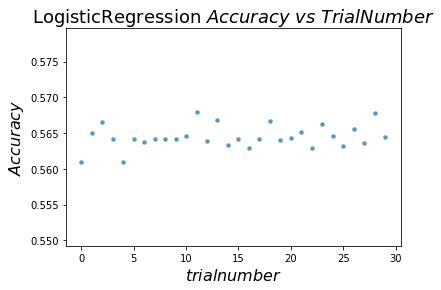

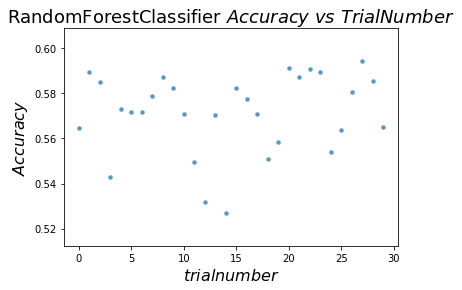

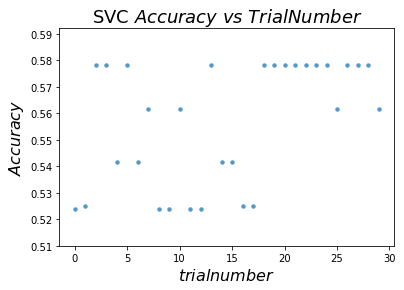

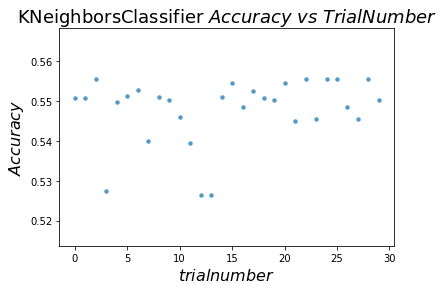

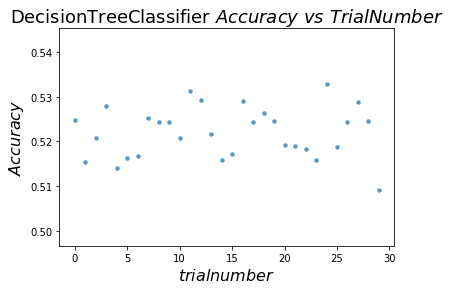

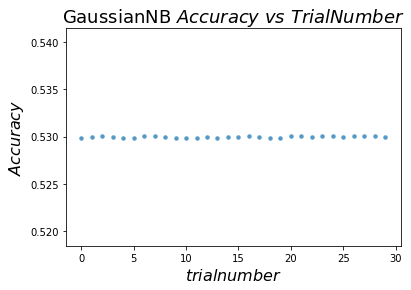

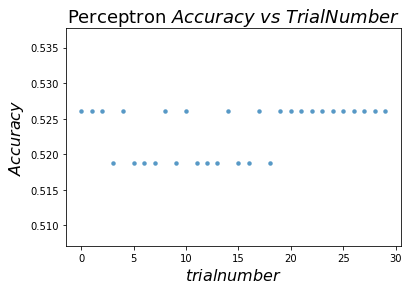

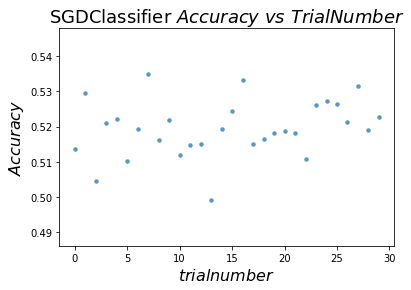

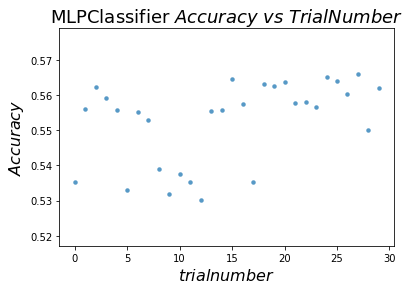

In [15]:
for model in models:
    model_name = type(model).__name__

    print(model_name)

    space = get_space(model) # Get space

   # number_of_evals = get_max_evals(model_name) # get_max_evals from testing
    trials = Trials()
    best_h = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=30, trials = trials)
    
    # Plot accuracy over evaluations
    f, ax = plt.subplots(1)
    xs = [t['tid'] for t in trials.trials]
    ys = [1 - t['result']['loss'] for t in trials.trials]
    ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
    ax.set_title(model_name + ' $Accuracy$ $vs$ $Trial Number$ ', fontsize=18)
    ax.set_xlabel('$trial number$', fontsize=16)
    ax.set_ylabel('$Accuracy$', fontsize=16)
    
    opt_hp = space_eval(space, best_h)

    max_evals_dict['hyper_opt_par'].append(opt_hp)

    print(opt_hp)
    del opt_hp['model']

    # create new model with tuned hyperparameters
    if model_name == "RandomForestClassifier":
        ht_model = RandomForestClassifier(**opt_hp)

    elif model_name == "KNeighborsClassifier":
        ht_model = KNeighborsClassifier(**opt_hp)

    elif model_name == "LogisticRegression":
        ht_model = LogisticRegression(**opt_hp)
    elif model_name == "SVC":
        ht_model = svm.SVC(**opt_hp)
    elif model_name == "DecisionTreeClassifier":
        ht_model = DecisionTreeClassifier(**opt_hp)
    elif model_name == "GaussianNB":
        ht_model = GaussianNB(**opt_hp)
    elif model_name == "Perceptron":
        ht_model = Perceptron(**opt_hp)
    elif model_name == "SGDClassifier":
        ht_model = SGDClassifier(**opt_hp)
    elif model_name == "MLPClassifier":
        ht_model = MLPClassifier(**opt_hp)




    scoring_stats = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc'}    



    # Calculate scores
    avg_scores = cross_validate(ht_model, X, y, cv=5, scoring = scoring_stats)

    accuracy = np.mean(avg_scores['test_accuracy'])


    # append to dictionary
    max_evals_dict['model_name'].append(model_name)
    max_evals_dict['accuracy'].append(accuracy)
    max_evals_dict['hp_dict'].append(opt_hp)

In [16]:
pd.DataFrame(max_evals_dict)

,hyper_opt_par,model_name,accuracy,hp_dict
0,"{'dual': True, 'fit_intercept': False}",LogisticRegression,0.566249,"{'dual': True, 'fit_intercept': False}"
1,"{'max_depth': 6, 'max_features': 49, 'n_estima...",RandomForestClassifier,0.589370,"{'max_depth': 6, 'max_features': 49, 'n_estima..."
2,"{'kernel': 'rbf', 'shrinking': True}",SVC,0.578099,"{'kernel': 'rbf', 'shrinking': True}"
3,"{'algorithm': 'brute', 'leaf_size': 55, 'n_nei...",KNeighborsClassifier,0.555400,"{'algorithm': 'brute', 'leaf_size': 55, 'n_nei..."
4,"{'criterion': 'gini', 'max_features': 'sqrt', ...",DecisionTreeClassifier,0.530077,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
5,{'var_smoothing': 0.0008511802027851444},GaussianNB,0.530090,{'var_smoothing': 0.0008511802027851444}
6,"{'alpha': 0.0004962053013128731, 'fit_intercep...",Perceptron,0.526034,"{'alpha': 0.0004962053013128731, 'fit_intercep..."
7,"{'fit_intercept': False, 'loss': 'hinge'}",SGDClassifier,0.513737,"{'fit_intercept': False, 'loss': 'hinge'}"
8,{'activation': 'identity'},MLPClassifier,0.562052,{'activation': 'identity'}
